In [113]:
import numpy as np
import matplotlib 
import matplotlib as mpl

from astropy.table import Table 
from astropy.stats import LombScargle

import glob, re
from halophot.halo_tools import get_pgram
from scipy.signal import savgol_filter

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=18              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter1d


Populating the interactive namespace from numpy and matplotlib


In [3]:
fname = '../data/manifold_dataset.csv'
cat = Table.read(fname)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


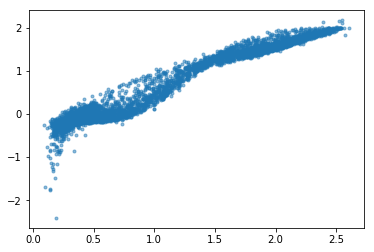

In [4]:
plt.plot(np.log10(cat['snr95']),np.log10(cat['skewness']),'.',alpha=0.5)

In [5]:
pulsators = cat[cat['snr95']>(10**1.5)]

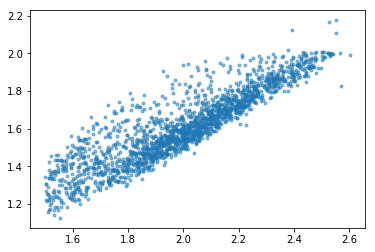

In [6]:
plt.plot(np.log10(pulsators['snr95']),np.log10(pulsators['skewness']),'.',alpha=0.5)

### Download some data 

In [9]:
datasets = glob.glob('../dsct/*')

In [35]:
kics = [re.match('.*(?<=dsct/kic)(.*)(?=_appended)',fname).group(1) for fname in datasets]

In [106]:
data = Table.read(datasets[0],format='ascii')
frequency, power, spower  = get_pgram(data['col1'],data['col2'])

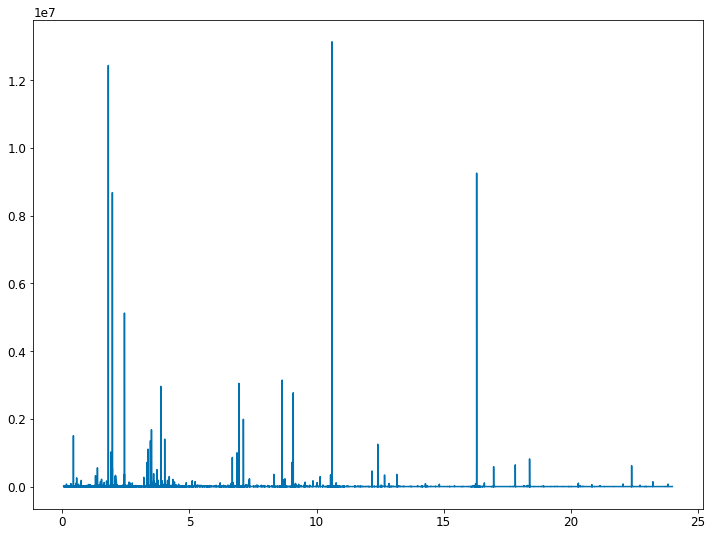

In [107]:
plt.plot(frequency,power)

In [114]:
n_bins = frequency.shape[0]/30
indices = np.array_split(np.arange(len(frequency)), n_bins)
binned_freq = np.array([np.mean(frequency[a]) for a in indices])
binned_spower = np.array([np.mean(spower[a]) for a in indices])
print(binned_freq.shape)

(5869,)


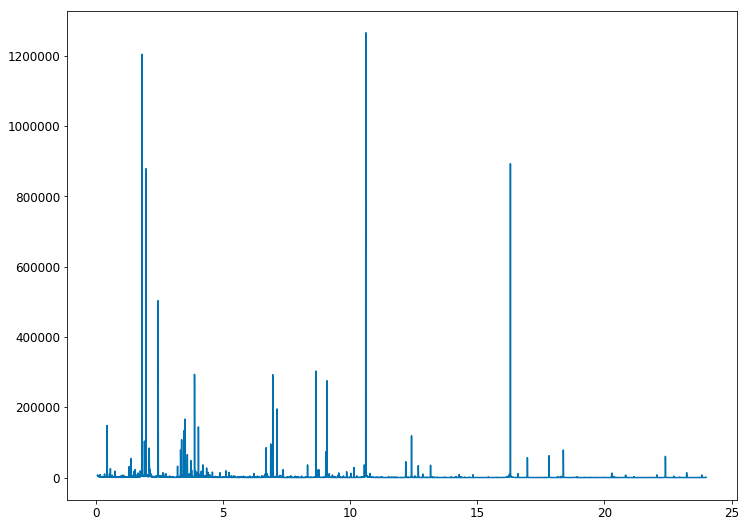

In [109]:
plt.plot(binned_freq,binned_spower)

### Now do all!

In [116]:
%%time
npgrams = 200
pgrams = np.zeros((binned_freq.shape[0],npgrams))
for j, dataset in enumerate(datasets[:npgrams]):
    if (j % 10) == 0:
        print(j)
    data = Table.read(dataset,format='ascii')
    ls = LombScargle(data['col1'],data['col2'],normalization='psd')
    power = ls.power(frequency)
    spower = savgol_filter(power,51,1)
    binned_spower = np.array([np.mean(spower[a]) for a in indices])
    pgrams[:,j] = binned_spower

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
CPU times: user 11min 3s, sys: 41.5 s, total: 11min 44s
Wall time: 10min 11s


In [117]:
from sklearn.preprocessing import normalize

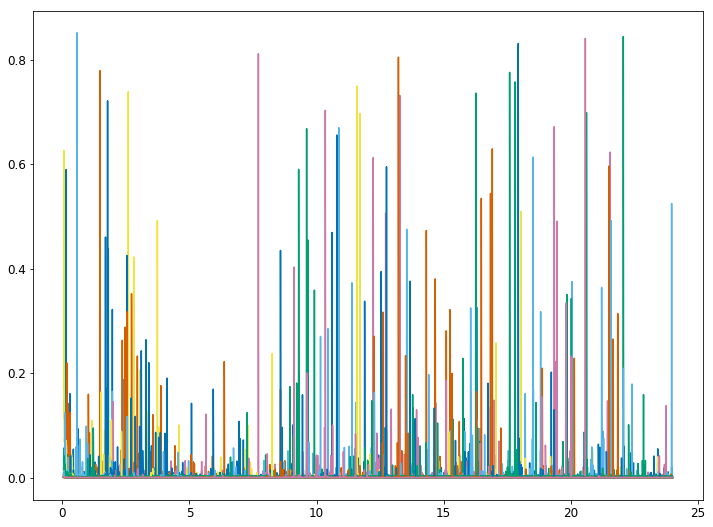

In [119]:
grams = normalize(pgrams,axis=0) # best to normalize for good machine learning performance
for j in range(int(grams.shape[1]/5)):
    plt.plot(binned_freq,grams[:,j])

In [64]:
from sklearn import manifold

In [120]:
%%time
n_neighbors = 20
n_components = 2
X = grams.T

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','Spectral Embedding', 't-SNE']
ys = []
for i, method in enumerate(methods):
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform((X))
    ys.append(Y)

Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
ys.append(Y)

mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
ys.append(Y)

se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
ys.append(Y)

tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
ys.append(Y)

CPU times: user 8.8 s, sys: 684 ms, total: 9.48 s
Wall time: 8.53 s


In [121]:
skews = np.array([cat['skewness'][cat['kic']==int(kic)] for kic in kics]).flatten()
snrs = np.array([cat['snr95'][cat['kic']==int(kic)] for kic in kics]).flatten()
teffs = np.array([cat['Teffi'][cat['kic']==int(kic)] for kic in kics]).flatten()
peaks = np.array([cat['freq'][cat['kic']==int(kic)] for kic in kics]).flatten()

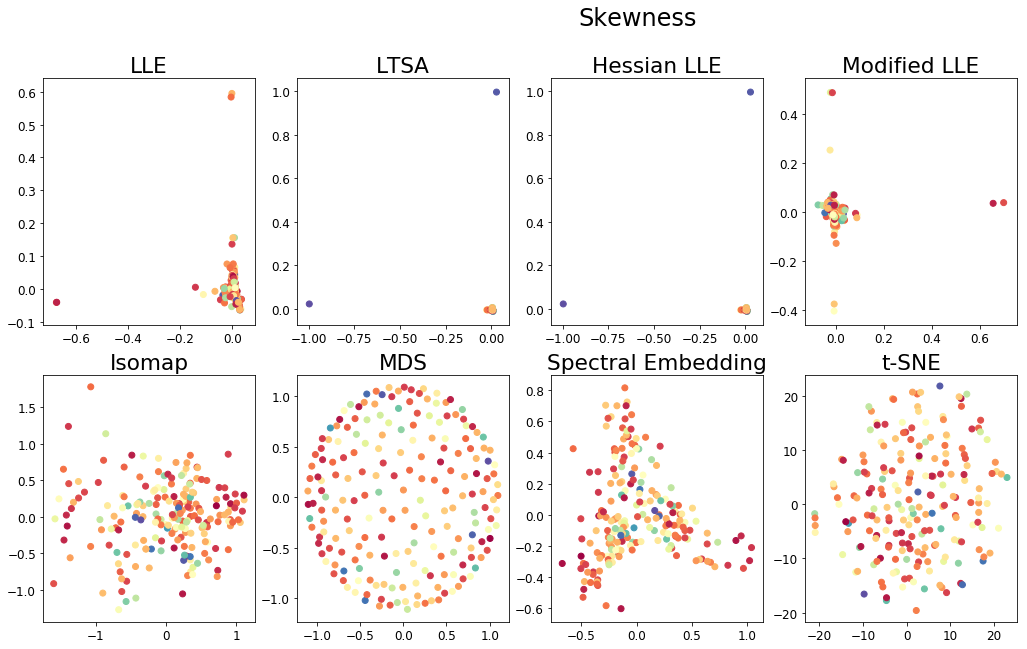

In [122]:
fig = plt.figure(figsize=(22, 10))
plt.suptitle("Skewness", fontsize=24)

jj = np.arange(len(labels))
jj[4:] += 1

for i, label in enumerate(labels):
    Y = ys[i]
    ax = fig.add_subplot(251 + jj[i])
    plt.scatter(Y[:, 0], Y[:, 1],c=skews[:npgrams], cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.title(label)
plt.savefig('skews_embedding.png')

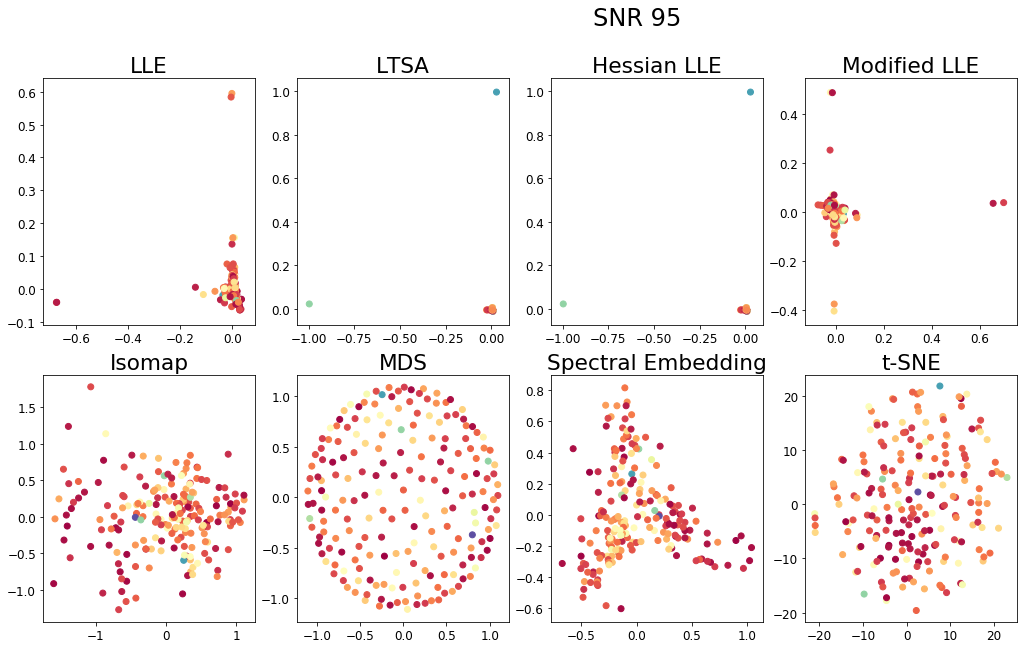

In [123]:
fig = plt.figure(figsize=(22, 10))
plt.suptitle("SNR 95", fontsize=24)

jj = np.arange(len(labels))
jj[4:] += 1

for i, label in enumerate(labels):
    Y = ys[i]
    ax = fig.add_subplot(251 + jj[i])
    plt.scatter(Y[:, 0], Y[:, 1],c=snrs[:npgrams], cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.title(label)
plt.savefig('snrs_embedding.png')

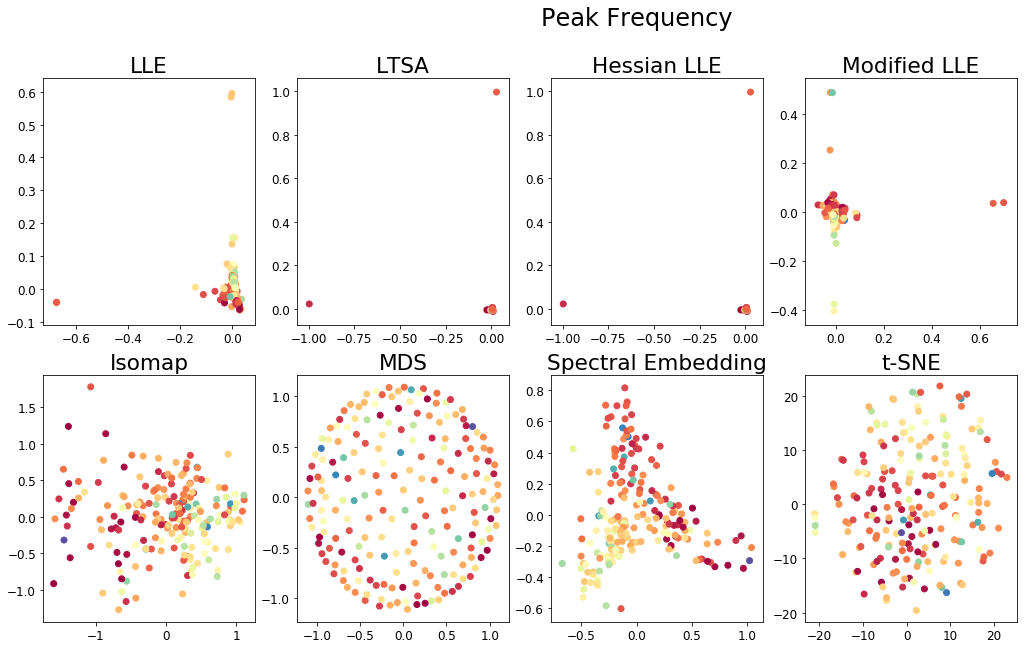

In [124]:
fig = plt.figure(figsize=(22, 10))
plt.suptitle("Peak Frequency", fontsize=24)

jj = np.arange(len(labels))
jj[4:] += 1

for i, label in enumerate(labels):
    Y = ys[i]
    ax = fig.add_subplot(251 + jj[i])
    plt.scatter(Y[:, 0], Y[:, 1],c=peaks[:npgrams], cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.title(label)
plt.savefig('freq_embedding.png')

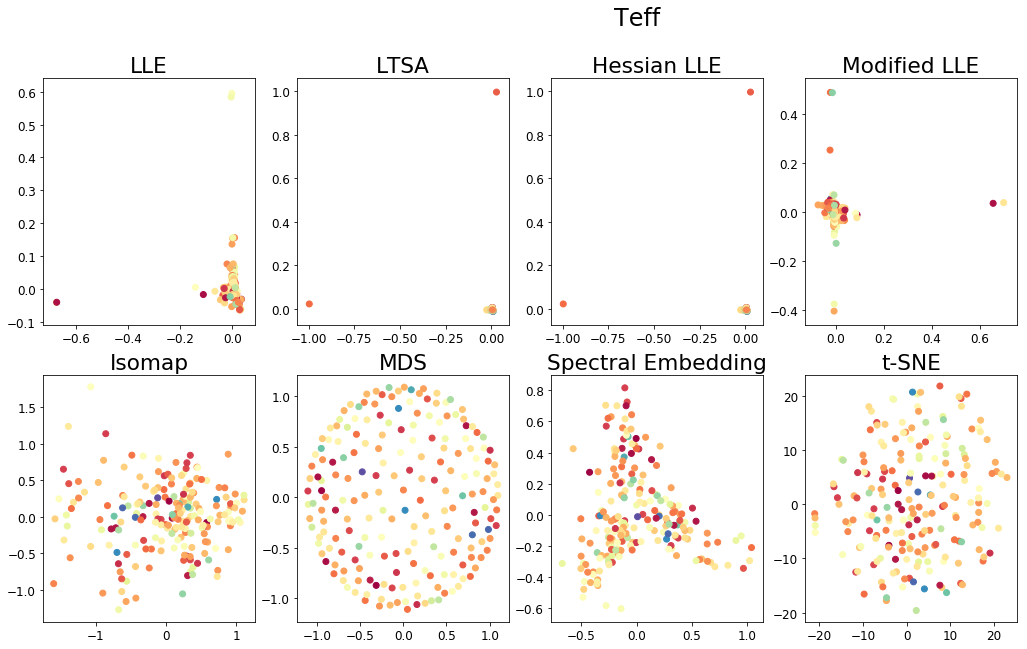

In [125]:
fig = plt.figure(figsize=(22, 10))
plt.suptitle("Teff", fontsize=24)

jj = np.arange(len(labels))
jj[4:] += 1

for i, label in enumerate(labels):
    Y = ys[i]
    ax = fig.add_subplot(251 + jj[i])
    plt.scatter(Y[:, 0], Y[:, 1],c=teffs[:npgrams], cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.title(label)
plt.savefig('teff_embedding.png')